In [1]:
import tensorflow as tf

In [2]:
import os
import urllib
import cv2
import numpy as np

In [3]:
from pixellib.semantic import semantic_segmentation

In [4]:
from matplotlib import pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
img_path = 'chroma_orc.jpg'
img_orig = cv2.imread(img_path)

(169, 298, 3)


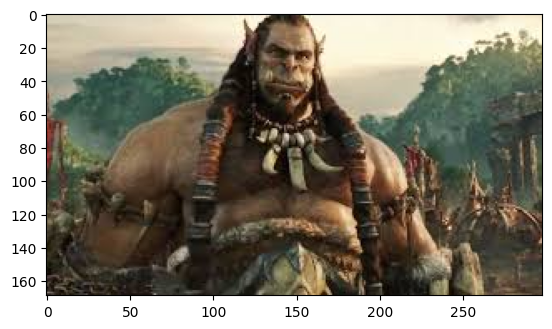

In [7]:
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
model_file = 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

In [9]:
#model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
#urllib.request.urlretrieve(model_url, model_file)

In [10]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file)

In [11]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [12]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

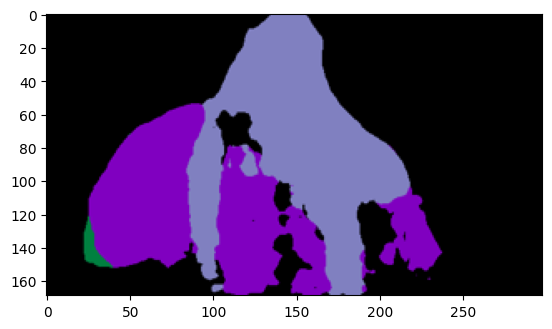

In [13]:
plt.imshow(output)
plt.show()

In [14]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cow
horse
person


In [15]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [20]:
colormap[10] # 소로 인식한 영역

array([ 64, 128,   0])

In [17]:
colormap[13] # 말로 인식한 영역

array([192,   0, 128])

In [19]:
colormap[15] # 사람로 인식한 영역

array([192, 128, 128])

In [24]:
# 3개 영역을 별개로 지정
hum_color = (128,128,192)
horse_color = (0,128,64)
cow_color = (128,0,192)

In [27]:
# 세그먼트 맵에 쓰기 위한 마스크 변수 할당
hum_mask = np.all(output == hum_color, axis=-1)       # 사람 부분
horse_mask = np.all(output == horse_color, axis=-1)   # 말 부분
cow_mask = np.all(output == cow_color, axis=-1)       # 소 부분

(169, 298)


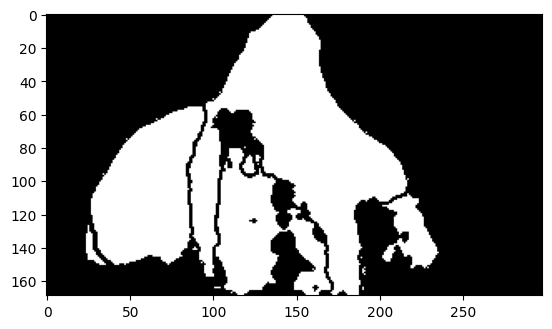

In [28]:
#세그먼트 이미지 확인
seg_map = hum_mask | horse_mask | cow_mask
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

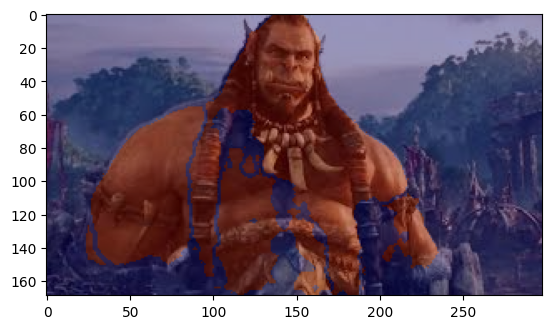

In [29]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

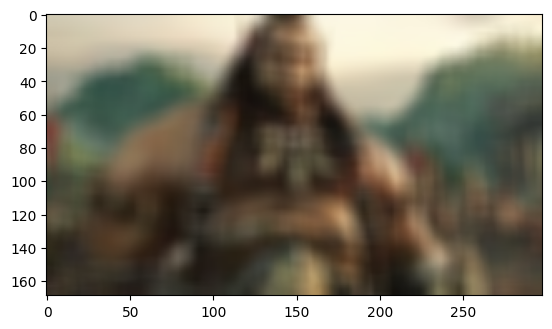

In [30]:
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

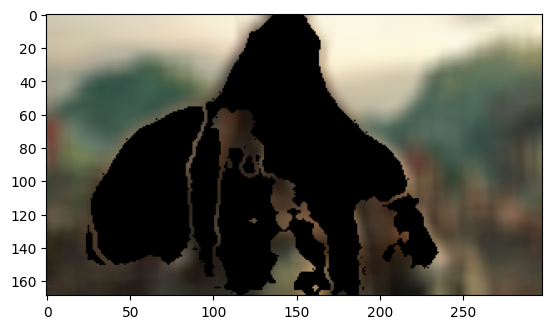

In [31]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

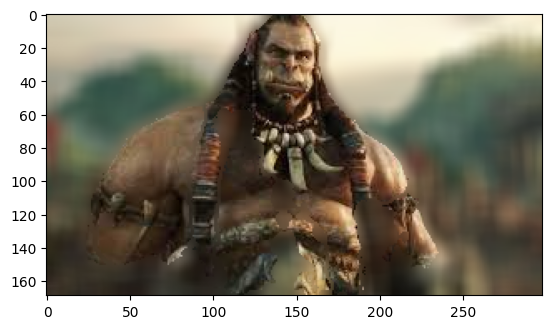

In [32]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### - 영화에 등장하는 인간을 형상을 닮은 상상 속의 종족을 segment했더니 사람, 소, 말 3개의 이미로 세그먼트함
#### - DeepLab 모델에게는 해당 캐릭터를 인간으로 볼만한 근거가 없어보이며 추가학습이 필요할 것으로 보임 